In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from tqdm.auto import tqdm

plt.rcParams['font.family'] = "Times New Roman"
LABEL_SIZE = 16
plt.rcParams['axes.labelsize'] = LABEL_SIZE
LEGEND_SIZE = 16
plt.rcParams['legend.fontsize'] = LEGEND_SIZE
AXIS_LABEL_SIZE = 12
plt.rcParams['xtick.labelsize'] = AXIS_LABEL_SIZE  # Set x-axis tick label size
plt.rcParams['ytick.labelsize'] = AXIS_LABEL_SIZE  # Set y-axis tick label size

In [2]:
import os
import json
import wandb
import numpy as np

RELOAD_RUNS = False

def filter_baseline(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("w_quant") == "NoQuantizer" and
        run.config.get("a_quant") == "NoQuantizer" and
        run.config.get("g_quant") == "NoQuantizer" and
        run.config.get("special_scheme") == None
    )

def filter_quartetv2(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("special_scheme") == "quartet_v2"
    )

def filter_nvidia(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("special_scheme") == "nvidia"
    )

def filter_tetrajetv2(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("special_scheme") == "tetrajetv2"
    )

def filter_backward_main(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("w_quant") == "NoQuantizer" and
        run.config.get("a_quant") == "NoQuantizer" and
        run.config.get("g_quant") == "EdenSRQuantizer" and
        len(set(run.tags) & set(["wrong_group_eden", "eden_nooverride", "htmatch"])) == 0
        and "triton" in run.tags
    )

def filter_backward_quartet(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("w_quant") == "NoQuantizer" and
        run.config.get("a_quant") == "NoQuantizer" and
        run.config.get("g_quant") == "EdenSRQuantizer" and
        "htmatch" in run.tags
    )

def orig_albert_tseng(run) -> bool:
    return final_loss is not None and \
        run.config.get("g_quant") == "AlbertTsengQuantizer" and \
        "tseng_wrong_sign" in run.tags

def fixed_albert_tseng(run) -> bool:
    return final_loss is not None and \
        run.config.get("g_quant") == "AlbertTsengQuantizer" and \
        "tseng_wrong_sign" not in run.tags

def filter_forward_main(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("w_quant") == "Nvfp4Quantizer" and
        run.config.get("a_quant") == "Nvfp4Quantizer" and
        run.config.get("g_quant") == "NoQuantizer"
    )

def filter_forward_quartet(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("w_quant") == "QuestNvfp4Quantizer" and
        run.config.get("g_quant") == "NoQuantizer"
    )

def filter_bnrq(run) -> bool:
    return (
        final_loss is not None and
        run.config.get("g_quant") == "IsolatedEdenQuantizer" and
        len(set(run.tags) & set(["isol-old"])) == 0
        and "triton" in run.tags
    )




filters = {
    "baseline": filter_baseline,
    "quartetv2": filter_quartetv2,
    "nvidia": filter_nvidia,
    "tetrajetv2": filter_tetrajetv2,
    "backward_main": filter_backward_main,
    "backward_quartet": filter_backward_quartet,
    "forward_quartet": filter_forward_quartet,
    "orig_albert_tseng": orig_albert_tseng,
    "fixed_albert_tseng": fixed_albert_tseng,
    "forward_main": filter_forward_main,
    "bnrq": filter_bnrq,
}

runs = {
    key: [] for key in filters
}

if RELOAD_RUNS:
    # Initialize W&B API client
    api = wandb.Api(timeout=29)

    # Fetch runs from your project
    project_runs = api.runs("ist/backprop-scaling-laws")

    # Iterate over runs and extract confusion matrix data
    for run in tqdm(project_runs):
        # This is a placeholder; you'll need to adjust it based on how you've logged your data
        
        model_size = int(run.name.split("-")[1][:-1]) if not run.name[0].isnumeric() else int(run.name.split("-")[0][:-1])
        final_loss = run.summary.get('final-val/loss')
        bquant = run.config.get("g_quant")
        fquant = run.config.get("f_quant")
        bquant_kwargs = run.config.get("g_quant_kwargs")
        fquant_kwargs = run.config.get("w_quant_kwargs")
        s_kwargs = run.config.get("special_scheme_kwargs", {})
        lr = run.config.get("lr")
        
        for key, filter in filters.items():
            if filter(run):
                tokens = run.config["iterations"] * run.config["batch_size"] * run.config["sequence_length"] * run.config["acc_steps"] * run.config["world_size"]
                non_embedding_parameters = run.summary["non_embedding_parameters"]
                
                runs[key].append({
                    'Nstr': model_size,
                    'N': non_embedding_parameters,
                    'final_loss': final_loss,
                    'D': tokens,
                    'D/N': tokens / non_embedding_parameters,
                    'bops': non_embedding_parameters * tokens,
                    
                    # Forward
                    'fquant': fquant,
                    'fsquare': fquant_kwargs.get('square'),
                    'fscale_override': fquant_kwargs.get('scale_override', 1.00),
                    'fhadamard_dim': fquant_kwargs.get('hadamard_dim'),
                    'ffour_over_six': fquant_kwargs.get('four_over_six', False),
                    
                    # Backward
                    'bquant': bquant,
                    'bunbiased': bquant_kwargs.get('unbiased'),
                    'bgroup_dim': bquant_kwargs.get('group_dim'),
                    'bscale_dtype': bquant_kwargs.get('scale_dtype'),
                    'bscale_override': bquant_kwargs.get('scale_override', 1.00),
                    'bstochastic': bquant_kwargs.get('stochastic'),
                    'bhadamard_dim': bquant_kwargs.get('hadamard_dim'),
                    'bbackward_scheme': run.config.get('backward_scheme'),
                    'bfour_over_six': bquant_kwargs.get('four_over_six', False),
                    
                    # Special
                    'sscheme': run.config.get("special_scheme"),
                    'shadamard_dim': s_kwargs.get('hadamard_dim', 32),
                    'sdelayed_amax': s_kwargs.get('delayed_amax', False),
                    'sfour_over_six': s_kwargs.get('four_over_six', False),
                })

    with open("../for_plots/runs.json", "w") as f:
        json.dump(runs, f)
else:
    with open("../for_plots/runs.json", "r") as f:
        runs = json.load(f)

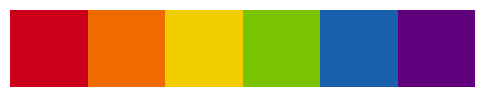

In [3]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt  # Added for plotting

str_size_to_int = {
    "30M": 30482560,
    "50M": 49556736,
    "100M": 102777856,
    "200M": 203188480,
    # "430M": 443068288,
    # "800M": 822151168,
}
linestyles = {
    "30M": "-",
    "50M": "--",
    "100M": "-.",
    "200M": "dotted",
    "430M": (0, (1, 4)),
    "800M": (0, (1, 8)),
}
markers = {
    "30M": "o",
    "50M": "s",
    "100M": "^",
    "200M": ">",
    "430M": "v",
    "800M": "<",
}

red = "#cd001a"
orange = "#ef6a00"
yellow = "#f2cd00"
green = "#79c300"
blue = "#1961ae"
purple = "#61007d"

# Create a figure displaying four squares, each with a different main color.
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlim(0, 6)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis("off")

# Draw one square per color
for i, color in enumerate([red, orange, yellow, green, blue, purple]):
    square = plt.Rectangle((i, 0), 1, 1, facecolor=color)
    ax.add_patch(square)

fig.savefig("../figures/color_scheme.pdf", transparent=True, bbox_inches="tight")
plt.show()


In [4]:
# (group_dim, scale_dtype, unbiased) -> (eff_bitwidth, magnitude_misalignment)

errors = {(128, 'fp32', 'no'): (3.2101259231567383, 0.010823249816894531),
 (128, 'fp32', 'sr'): (2.6884593963623047, -3.24249267578125e-05),
 (128, 'fp32', 'eden'): (3.214914083480835, 0.0),
 (16, 'e4m3', 'no'): (3.399279832839966, 0.007816076278686523),
 (16, 'e4m3', 'sr'): (2.7048749923706055, -5.0067901611328125e-06),
 (16, 'e4m3', 'eden'): (3.3395779132843018, 0.0005617737770080566),
 (32, 'e8m0', 'no'): (3.1589698791503906, 0.011465072631835938),
 (32, 'e8m0', 'sr'): (2.584864377975464, -1.1920928955078125e-07),
 (32, 'e8m0', 'eden'): (2.6266121864318848, -1.0728836059570312e-05)}

In [5]:
optimal_scale_override = {
    "eden": {
        "fp32": 0.96,
        "e4m3": 0.93,
        "e8m0": 0.91,
    },
    "no": {
        "fp32": 0.96,
        "e4m3": 0.93,
        "e8m0": 0.84,
    },
    "sr": {
        "fp32": 1.00,
        "e4m3": 1.00,
        "e8m0": 1.00,   
    },
}

In [6]:
from scipy.optimize import least_squares

/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/1777578199.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticklabels)
/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/1777578199.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticklabels)
/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/1777578199.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticklabels)
/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/1777578199.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticklabels)


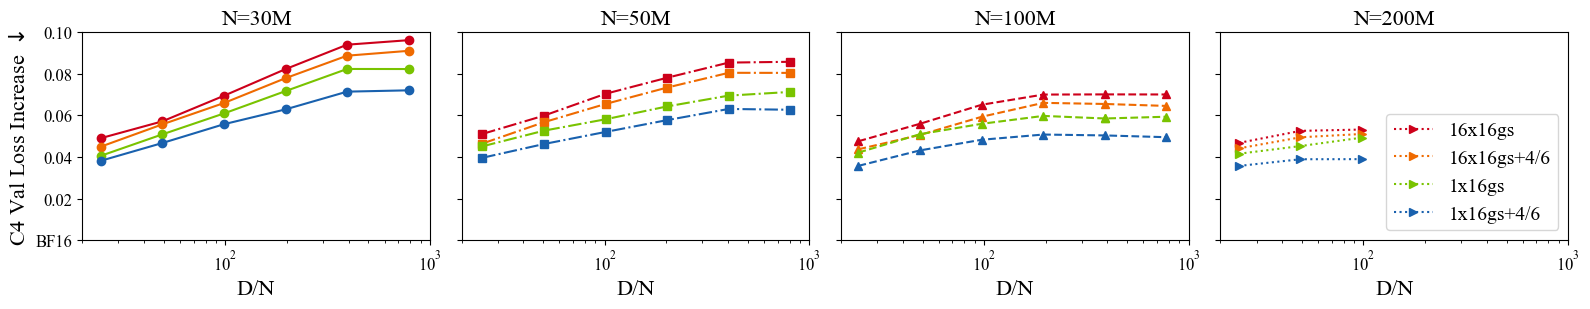

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3.2), sharex=True, sharey=True)

square_fos_hadamard_color = {
    (True, False, 1): (red, "16x16gs"),
    (True, True, 1): (orange, "16x16gs+4/6"),
    (False, False, 1): (green, "1x16gs"),
    (False, True, 1): (blue, "1x16gs+4/6"),
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
    "200M": "dotted",
}

baselines = {
    (run['N'], run['D/N']): run['final_loss'] for run in runs['baseline']
}

for (size, linestyle), ax in zip(linestyles.items(), axs):
    last_gaps = {}
    for (square, fos, hadamard_dim), (color, label) in square_fos_hadamard_color.items():
        filtered = [
            run for run in runs['forward_main'] if
            run['fscale_override'] == 1.0 and
            run['fsquare'] == square and
            run['fhadamard_dim'] == hadamard_dim and
            run['ffour_over_six'] == fos and
            run['N'] == str_size_to_int[size]
        ]
        
        if len(filtered) == 0:
            continue
        
        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        
        last_point = filtered_sorted[-1]
        last_gaps[(square, 1.0, hadamard_dim)] = (
            float(last_point['final_loss']) - baselines[(last_point['N'], last_point['D/N'])]
        )
        
        
        ax.plot(
            [run['D/N'] for run in filtered_sorted],
            [float(run['final_loss']) - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
            color=color, linestyle=linestyle, marker=markers[size],
            label=label
        )
    
    ax.set_title(f"N={size}", fontsize=16)
    ax.set_xlabel("D/N")

    if size == "30M":
        ax.set_ylabel(r"C4 Val Loss Increase $\downarrow$")
    if size == "200M":
        ax.legend(loc="lower right", fontsize=14)
    ax.set_xlim(20, 1000)
    ax.set_ylim(-0.000, 0.10)
    ax.set_xscale('log')
    
    y_ticks = ax.get_yticks()
    y_ticklabels = [f"{y:.2f}" if abs(y) > 1e-8 else "BF16" for y in y_ticks]
    ax.set_yticklabels(y_ticklabels)

fig.tight_layout()

fig.savefig("../figures/forward.pdf", transparent=True, bbox_inches="tight")

plt.show()

/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/295036668.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(y_ticklabels)


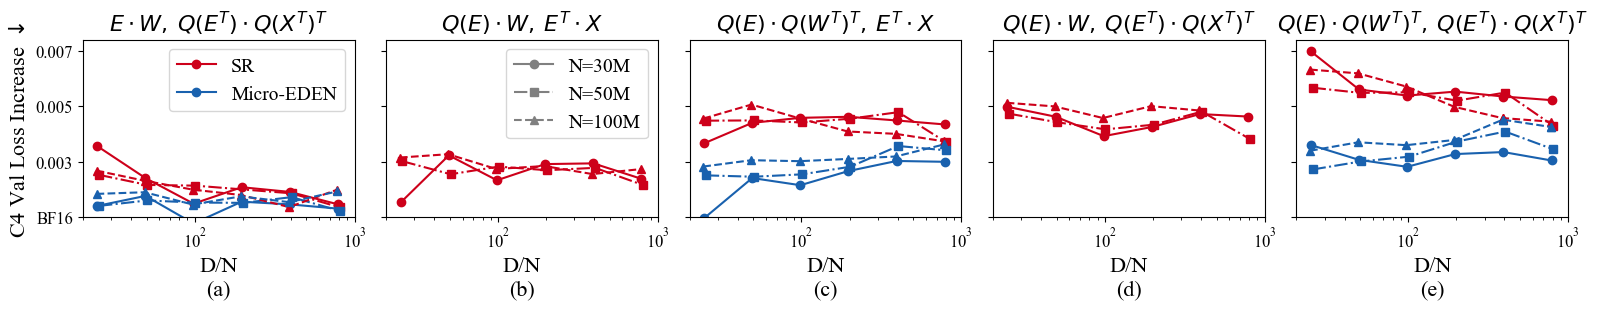

In [8]:
PLOT_AS_FIT = False

fig, axs = plt.subplots(1, 5, figsize=(16, 3.2), sharey=True)

############ EtX ############### 
ax = axs[0]

unbiases_scales_to_color = {
    ("sr", 1.0): red,
    ("eden", optimal_scale_override["eden"]["e4m3"]): blue,
    # ("no", optimal_scale_override["no"]["e4m3"]): purple,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
}

baselines = {
    (run['N'], run['D/N']): run['final_loss'] for run in runs['baseline']
}


unbiased_override_points = defaultdict(list)

for size, n_param in str_size_to_int.items():
    for (unbiased, scale_override), color  in unbiases_scales_to_color.items():             
        filtered = [
            run for run in runs['backward_main'] if
            run['bbackward_scheme'] == "EW_Q(Et)Q(Xt)t" and
            run['bunbiased'] == unbiased and
            run['bscale_dtype'] == "e4m3" and
            run['bscale_override'] == scale_override and
            run['bgroup_dim'] == 16 and
            run['bhadamard_dim'] == 128 and
            run['N'] == n_param
        ]
        
        if len(filtered) == 0:
            continue
        
        # Errors
        eff_bitwidth, magnitude_misalignment = errors[(16, "e4m3", unbiased)]

        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        if PLOT_AS_FIT:
            points_fn = ax.scatter
        else:
            points_fn = ax.plot
        points_fn(
            [run['D/N'] for run in filtered_sorted],
            [run['final_loss'] - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
            color=color, linestyle=linestyles[size], marker=markers[size],
            label=f"{'Micro-EDEN' if unbiased == 'eden' else 'SR'}" if size=="30M" else None
        )
        
        unbiased_override_points[(unbiased, scale_override)].extend([
            (run['D/N'], run['final_loss'] - baselines[(run['N'], run['D/N'])])
            for run in filtered
        ])
        
        ax.set_title(r"$E\cdot W,\:Q(E^T)\cdot Q(X^T)^T$", fontsize=16)
            
        ax.set_xlabel("D/N\n(a)")
        ax.set_ylabel(r"C4 Val Loss Increase $\downarrow$")
        ax.legend(loc="upper right", fontsize=14)
        ax.set_xscale('log')
        ax.set_xlim(20, 1000)
        ax.set_ylim(-0.000, 0.012)
        
if PLOT_AS_FIT:
    for (unbiased, scale_override), points in unbiased_override_points.items():
        x_vals = np.array([np.log(p[0]) for p in points])
        y_vals = np.array([p[1] for p in points])
        
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        
        x_fit = np.linspace(20, 1000, 100)
        y_fit = slope * np.log(x_fit) + intercept
        
        ax.plot(
            x_fit, 
            y_fit, 
            color=unbiases_scales_to_color[(unbiased, scale_override)], 
            linestyle='--'
        )



############# Q(E)W_EtX ##################
ax = axs[1]
unbiased_scale_hadamard_color = {
    ("sr", 1): red,
    # ("eden", 128): blue,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
}

unbiased_scale_hadamard_norequant_points = defaultdict(list)

for size, linestyle in linestyles.items():
    for (unbiased, hadamard_dim), color in unbiased_scale_hadamard_color.items():
        filtered = [
            run for run in runs['bnrq'] if
            run['bhadamard_dim'] == hadamard_dim and
            run['bbackward_scheme'] == "Q(E)W_EtX" and
            run['bunbiased'] == unbiased and
            run['N'] == str_size_to_int[size]
        ]
        
        if len(filtered) == 0:
            continue
        
        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        if PLOT_AS_FIT:
            plt_fn = ax.scatter
        else:
            plt_fn = ax.plot
        plt_fn(
            [run['D/N'] for run in filtered_sorted],
            [float(run['final_loss']) - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
            color=color, linestyle=linestyle, marker=markers[size],
            label=f"{'Micro-EDEN' if unbiased == 'eden' else 'SR'}" if size=="30M" else None
        )
        
        unbiased_scale_hadamard_norequant_points[(unbiased, 1.0, hadamard_dim, True)].extend([
            (run['D/N'], run['final_loss'] - baselines[(run['N'], run['D/N'])])
            for run in filtered
        ])


    ax.set_title(r"$Q(E)\cdot W,\:E^T\cdot X$", fontsize=16)
    ax.set_xlabel("D/N\n(b)")
    ax.set_xlim(20, 1000)
    ax.set_xscale('log')
    
if PLOT_AS_FIT:
    for (unbiased, scale_override, hadamard_dim, norequant), points in unbiased_scale_hadamard_norequant_points.items():
        x_vals = np.array([np.log(p[0]) for p in points])
        y_vals = np.array([p[1] for p in points])
        
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        
        x_fit = np.linspace(20, 1000, 100)
        y_fit = slope * np.log(x_fit) + intercept
        
        ax.plot(
            x_fit, 
            y_fit, 
            color=(
                unbiased_scale_hadamard_color[(unbiased, hadamard_dim)]
                if norequant else
                unbiases_scales_color[(unbiased, scale_override)]
            ), 
            linestyle='--'
        )


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='grey', label=f"N={size}", linestyle=style, marker=markers[size])
    for size, style in linestyles.items()
]

# Apply the custom handles to the legend
ax.legend(handles=legend_elements, loc="upper right", fontsize=14)


############# EW ##################
ax = axs[2]
unbiases_scales_color = {
    ("sr", 1.0): red,
    ("eden", optimal_scale_override["eden"]["e4m3"]): blue,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
    "200M": "dotted",
}

unbiased_scale_hadamard_norequant_points = defaultdict(list)

for size, linestyle in linestyles.items():
    for (unbiased, scale_override), color in unbiases_scales_color.items():
        filtered = [
            run for run in runs['backward_main'] if
            run['bbackward_scheme'] == "Q(E)Q(Wt)t_EtX" and
            run['bunbiased'] == unbiased and
            run['bscale_dtype'] == "e4m3" and
            run['bscale_override'] == scale_override and
            run['bgroup_dim'] == 16 and
            run['bhadamard_dim'] == 128 and
            run['N'] == str_size_to_int[size]
        ]
        
        if len(filtered) == 0:
            continue
        
        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        if PLOT_AS_FIT:
            plt_fn = ax.scatter
        else:
            plt_fn = ax.plot
        plt_fn(
            [run['D/N'] for run in filtered_sorted],
            [float(run['final_loss']) - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
            color=color, linestyle=linestyle, marker=markers[size],
            label=f"{'Micro-EDEN' if unbiased == 'eden' else 'SR'}" if size=="30M" else None
        )
        
        unbiased_scale_hadamard_norequant_points[(unbiased, scale_override, 1, False)].extend([
            (run['D/N'], run['final_loss'] - baselines[(run['N'], run['D/N'])])
            for run in filtered
        ])


    ax.set_title(r"$Q(E)\cdot Q(W^T)^T,\:E^T\cdot X$", fontsize=16)
    ax.set_xlabel("D/N\n(c)")
    ax.set_xlim(20, 1000)
    ax.set_xscale('log')
    
if PLOT_AS_FIT:
    for (unbiased, scale_override, hadamard_dim, norequant), points in unbiased_scale_hadamard_norequant_points.items():
        x_vals = np.array([np.log(p[0]) for p in points])
        y_vals = np.array([p[1] for p in points])
        
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        
        x_fit = np.linspace(20, 1000, 100)
        y_fit = slope * np.log(x_fit) + intercept
        
        ax.plot(
            x_fit, 
            y_fit, 
            color=(
                unbiased_scale_hadamard_color[(unbiased, hadamard_dim)]
                if norequant else
                unbiases_scales_color[(unbiased, scale_override)]
            ), 
            linestyle='--'
        )


############# Q(E)W_Q(Et)Q(Xt)t ##################
ax = axs[3]
unbiased_scale_hadamard_color = {
    ("sr", 128): red,
    # ("eden", 128): blue,
}

unbiases_scales_color = {
    # ("sr", 1.0): green,
    # ("eden", optimal_scale_override["eden"]["e4m3"]): orange,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
    "200M": "dotted",
}

unbiased_scale_hadamard_norequant_points = defaultdict(list)

for size, linestyle in linestyles.items():
    # if size == "30M":
    #     ax.plot([], [], label="No W Requant", alpha=0.0)
    for (unbiased, hadamard_dim), color in unbiased_scale_hadamard_color.items():
        filtered = [
            run for run in runs['bnrq'] if
            run['bbackward_scheme'] == "Q(E)W_Q(Et)Q(Xt)t" and
            run['bhadamard_dim'] == hadamard_dim and
            run['bunbiased'] == unbiased and
            run['N'] == str_size_to_int[size]
        ]
        
        if len(filtered) == 0:
            continue
        
        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        if PLOT_AS_FIT:
            plt_fn = ax.scatter
        else:
            plt_fn = ax.plot
        plt_fn(
            [run['D/N'] for run in filtered_sorted],
            [float(run['final_loss']) - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
            color=color, linestyle=linestyle, marker=markers[size],
            label=f"{'Micro-EDEN' if unbiased == 'eden' else 'SR'}" if size=="30M" else None
        )
        
        unbiased_scale_hadamard_norequant_points[(unbiased, 1.0, hadamard_dim, True)].extend([
            (run['D/N'], run['final_loss'] - baselines[(run['N'], run['D/N'])])
            for run in filtered
        ])

    ax.set_title(r"$Q(E)\cdot W,\:Q(E^T)\cdot Q(X^T)^T$", fontsize=16)
    ax.set_xlabel("D/N\n(d)")
    ax.set_xlim(20, 1000)
    ax.set_xscale('log')
    
if PLOT_AS_FIT:
    for (unbiased, scale_override, hadamard_dim, norequant), points in unbiased_scale_hadamard_norequant_points.items():
        x_vals = np.array([np.log(p[0]) for p in points])
        y_vals = np.array([p[1] for p in points])
        
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        
        x_fit = np.linspace(20, 1000, 100)
        y_fit = slope * np.log(x_fit) + intercept
        
        ax.plot(
            x_fit, 
            y_fit, 
            color=(
                unbiased_scale_hadamard_color[(unbiased, hadamard_dim)]
                if norequant else
                unbiases_scales_color[(unbiased, scale_override)]
            ), 
            linestyle='--'
        )


############# Q(E)Q(Wt)t_Q(Et)Q(Xt)t ##################
ax = axs[4]

unbiased_scale_color = {
    ("sr", 1.00): red,
    ("eden", optimal_scale_override["eden"]["e4m3"]): blue,
}

baselines = {
    (run['N'], run['D/N']): run['final_loss'] for run in runs['baseline']
}

unbiased_scale_points = defaultdict(list)

for size, n_param in str_size_to_int.items():
        for (unbiased, scale_override), color in unbiased_scale_color.items():
            filtered = [
                run for run in runs['backward_main'] if
                run['bbackward_scheme'] == "Q(E)Q(Wt)t_Q(Et)Q(Xt)t" and
                run['bunbiased'] == unbiased and
                run['bscale_dtype'] == "e4m3" and
                run['bscale_override'] == scale_override and
                run['bgroup_dim'] == 16 and
                run['bhadamard_dim'] == 128 and
                run['N'] == n_param
            ]
            
            if len(filtered) == 0:
                continue
            
            # Errors
            eff_bitwidth, magnitude_misalignment = errors[(16, "e4m3", unbiased)]
            

            filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
            if PLOT_AS_FIT:
                points_fn = ax.scatter
            else:
                points_fn = ax.plot
            points_fn(
                [run['D/N'] for run in filtered_sorted],
                [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
                color=color, linestyle=linestyles[size], marker=markers[size],
                label=f"{'Micro-EDEN' if unbiased == 'eden' else 'SR'}" if size=="30M" else None # + r":\n\t{eff_bitwidth:.2f}bits eff, " + r"$1-\mathbb{E}(1/S)$=" + f"{magnitude_misalignment:.3f}")
            )
            unbiased_scale_points[(unbiased, scale_override)].extend([
                (run['D/N'], run['final_loss'] - baselines[(run['N'], run['D/N'])])
                for run in filtered
            ])

        ax.set_xlabel("D/N\n(e)")
        ax.set_title(r"$Q(E)\cdot Q(W^T)^T,\:Q(E^T)\cdot Q(X^T)^T$", fontsize=16)
        ax.set_xscale('log')
        ax.set_xlim(20, 1000)

if PLOT_AS_FIT:
    for (unbiased, scale_override), points in unbiased_scale_points.items():
        x_vals = np.array([np.log(p[0]) for p in points])
        y_vals = np.array([p[1] for p in points])
        
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        x_fit = np.linspace(20, 1000, 100)
        y_fit = slope * np.log(x_fit) + intercept
        
        ax.plot(
            x_fit, 
            y_fit, 
            color=unbiased_scale_color[(unbiased, scale_override)], 
            linestyle='--'
        )


ax.set_ylim(-0.000, 0.016)

y_ticks = axs[0].get_yticks()
y_ticklabels = [f"{y:.3f}" if abs(y) > 1e-8 else "BF16" for y in y_ticks]
axs[0].set_yticklabels(y_ticklabels)

fig.tight_layout()

fig.savefig("../figures/backward.pdf", transparent=True, bbox_inches="tight")

plt.show()

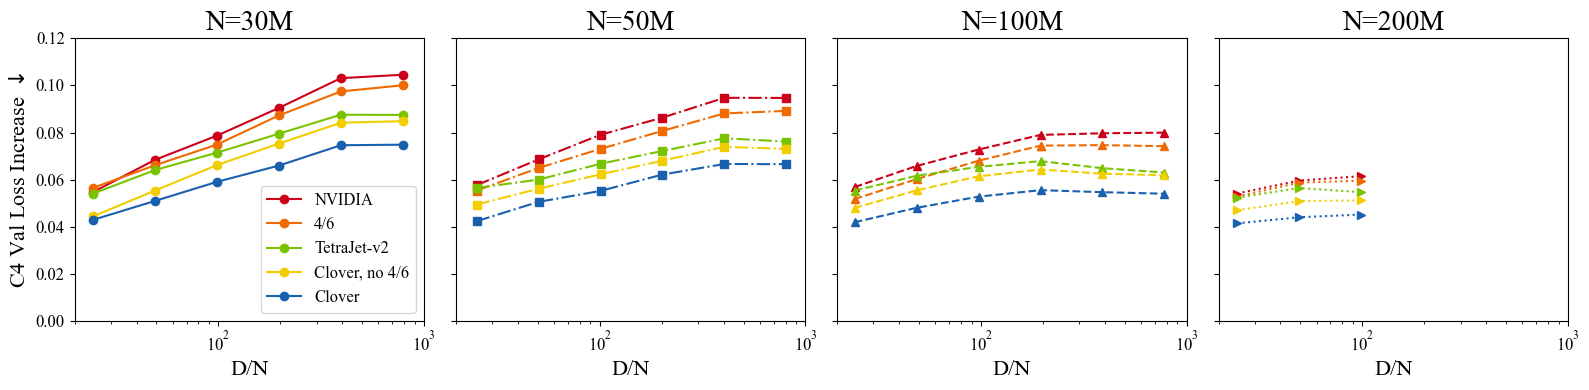

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

delayed_hdim_fos_color = {
    (False, 128, False): yellow,
    (False, 128, True): blue,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
    "200M": "dotted",
}

baselines = {
    (run['N'], run['D/N']): run['final_loss'] for run in runs['baseline']
}

for (size, linestyle), ax in zip(linestyles.items(), axs):
    # NVIDIA full
    filtered = [
        run for run in runs['nvidia'] if
        run['sfour_over_six'] == False and
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=red, linestyle=linestyle, marker=markers[size],
        label=f"NVIDIA" if size=="30M" else None
    )
    
    # 4/6
    filtered = [
        run for run in runs['nvidia'] if
        run['sfour_over_six'] == True and
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=orange, linestyle=linestyle, marker=markers[size],
        label=f"4/6" if size=="30M" else None
    )
    
    # TetraJet-v2
    filtered = [
        run for run in runs['tetrajetv2'] if
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=green, linestyle=linestyle, marker=markers[size],
        label=f"TetraJet-v2" if size=="30M" else None
    )
    
    # Quartet full
    for (delayed, hdim, fos), color in delayed_hdim_fos_color.items():
        filtered = [
            run for run in runs['quartetv2'] if
            run['sdelayed_amax'] == delayed and
            run['shadamard_dim'] == hdim and
            run['sfour_over_six'] == fos and
            run['Nstr'] == int(size[:-1])
        ]
        
        if len(filtered) == 0:
            continue

        filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
        ax.plot(
            [run['D/N'] for run in filtered_sorted],
            [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
            color=color, linestyle=linestyle, marker=markers[size],
            label=f"Clover{', no 4/6' if not fos else ''}" if size=="30M" else None 
        )
    

    # Quartet-II forward
    filtered = [
        run for run in runs['forward_main'] if
        run['fscale_override'] == 1.0 and
        run['fsquare'] == False and
        run['fhadamard_dim'] == 1 and
        run['N'] == str_size_to_int[size]
    ]
    
    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])    
    # ax.plot(
    #     [run['D/N'] for run in filtered_sorted],
    #     [float(run['final_loss']) - baselines[(run['N'], run['D/N'])] if (run['N'], run['D/N']) in baselines else None for run in filtered_sorted],
    #     color="gray", linestyle=linestyle, marker=markers[size],
    #     label=(
    #         "Quartet-II Forward-only"
    #     ) if size=="30M" else None
    # )

    ax.set_xlabel("D/N")
    if size == "30M":
        ax.set_ylabel(r"C4 Val Loss Increase $\downarrow$")
        ax.legend(loc="lower right", fontsize=12)
    ax.set_title(f"N={size}", fontsize=20)
    ax.set_xscale('log')
    ax.set_xlim(20, 1000)
    ax.set_ylim(0, 0.12)

fig.tight_layout()

/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/3107287108.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(y_ticklabels)


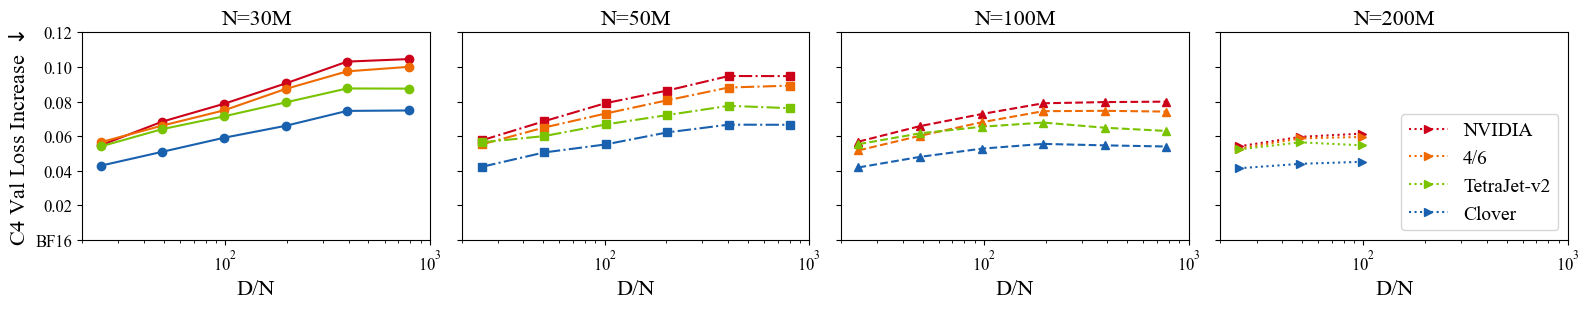

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3.2), sharex=True, sharey=True)
# axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]

delayed_hdim_fos_color = {
    # (False, 128, False): green,
    (False, 128, True): blue,
}

linestyles = {
    "30M": "-",
    "50M": "-.",
    "100M": "--",
    "200M": "dotted",
}

baselines = {
    (run['N'], run['D/N']): run['final_loss'] for run in runs['baseline']
}

for (size, linestyle), ax in zip(linestyles.items(), axs):
    # NVIDIA full
    filtered = [
        run for run in runs['nvidia'] if
        run['sfour_over_six'] == False and
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=red, linestyle=linestyle, marker=markers[size],
        label=f"NVIDIA"
    )
    
    # 4/6
    filtered = [
        run for run in runs['nvidia'] if
        run['sfour_over_six'] == True and
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=orange, linestyle=linestyle, marker=markers[size],
        label=f"4/6"
    )
    
    # TetraJet-v2
    filtered = [
        run for run in runs['tetrajetv2'] if
        run['Nstr'] == int(size[:-1])
    ]

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=green, linestyle=linestyle, marker=markers[size],
        label=f"TetraJet-v2"
    )
    
    # Quartet full
    filtered = [
        run for run in runs['quartetv2'] if
        run['sdelayed_amax'] == False and
        run['shadamard_dim'] == 128 and
        run['sfour_over_six'] == True and
        run['Nstr'] == int(size[:-1])
    ]
    
    if len(filtered) == 0:
        continue

    filtered_sorted = sorted(filtered, key=lambda run: run['D/N'])
    ax.plot(
        [run['D/N'] for run in filtered_sorted],
        [run['final_loss'] - baselines[(run['N'], run['D/N'])] for run in filtered_sorted],
        color=blue, linestyle=linestyle, marker=markers[size],
        label=f"Clover"
    )


    # Labels
    ax.set_xlabel("D/N")
    if size == "30M":
        ax.set_ylabel(r"C4 Val Loss Increase $\downarrow$")
    if size == "200M":
        ax.legend(loc="lower right", fontsize=14)
    ax.set_title(f"N={size}", fontsize=16)
    ax.set_xscale('log')
    ax.set_xlim(20, 1000)
    ax.set_ylim(0, 0.12)


y_ticks = axs[0].get_yticks()
y_ticklabels = [f"{y:.2f}" if abs(y) > 1e-8 else "BF16" for y in y_ticks]
axs[0].set_yticklabels(y_ticklabels)

fig.tight_layout()

fig.savefig("../figures/full.pdf", transparent=True, bbox_inches="tight")

plt.show()

# Nanochat

BF16

| Metric          | BASE     | MID      | SFT      | RL       |
|-----------------|----------|----------|----------|----------|
| CORE            | 0.2346   | -        | -        | -        |
| ARC-Challenge   | -        | 0.3857   | 0.3882   | -        |
| ARC-Easy        | -        | 0.5181   | 0.5737   | -        |
| GSM8K           | -        | 0.0023   | 0.1137   | -        |
| HumanEval       | -        | 0.1037   | 0.0305   | -        |
| MMLU            | -        | 0.3563   | 0.3548   | -        |
| ChatCORE        | -        | 0.2925   | 0.3140   | -        |

Quartet II

| Metric          | BASE     | MID      | SFT      | RL       |
|-----------------|----------|----------|----------|----------|
| CORE            | 0.2189   | -        | -        | -        |
| ARC-Challenge   | -        | 0.3788   | 0.3677   | -        |
| ARC-Easy        | -        | 0.4996   | 0.5354   | -        |
| GSM8K           | -        | 0.0008   | 0.0766   | -        |
| HumanEval       | -        | 0.0427   | 0.0122   | -        |
| MMLU            | -        | 0.3477   | 0.3536   | -        |
| ChatCORE        | -        | 0.2778   | 0.2921   | -        |

NVIDIA
| Metric          | BASE     | MID      | SFT      | RL       |
|-----------------|----------|----------|----------|----------|
| CORE            | 0.2126   | -        | -        | -        |
| ARC-Challenge   | -        | 0.3626   | 0.3515   | -        |
| ARC-Easy        | -        | 0.4777   | 0.5248   | -        |
| GSM8K           | -        | 0.0008   | 0.0933   | -        |
| HumanEval       | -        | 0.0122   | 0.0183   | -        |
| MMLU            | -        | 0.3460   | 0.3501   | -        |
| ChatCORE        | -        | 0.2593   | 0.2859   | -        |

46
| Metric          | BASE     | MID      | SFT      | RL       |
|-----------------|----------|----------|----------|----------|
| CORE            | 0.2091   | -        | -        | -        |
| ARC-Challenge   | -        | 0.3746   | 0.3840   | -        |
| ARC-Easy        | -        | 0.5004   | 0.5244   | -        |
| GSM8K           | -        | 0.0030   | 0.0720   | -        |
| HumanEval       | -        | 0.0915   | 0.0366   | -        |
| MMLU            | -        | 0.3460   | 0.3522   | -        |
| ChatCORE        | -        | 0.2832   | 0.2963   | -        |


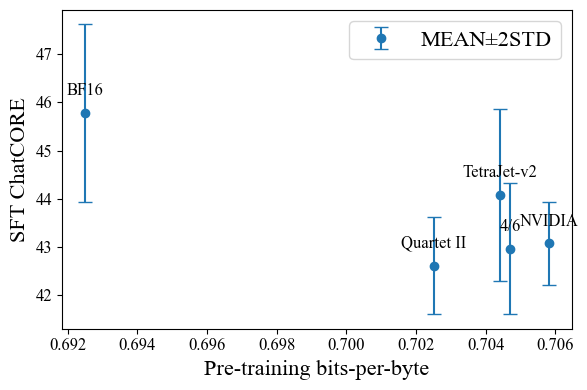

In [11]:
import matplotlib.pyplot as plt
import numpy as np

methods = ["BF16", "NVIDIA", "4/6", "TetraJet-v2", "Quartet II"]
bpbs = [0.6925, 0.7058, 0.7047, 0.7044, 0.7025]
means = [45.78, 43.07, 42.96, 44.08, 42.61]
stds = [0.92, 0.43, 0.68, 0.89, 0.50]

bpbs = np.array(bpbs)
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(6,4))
plt.errorbar(bpbs, means, yerr=2*np.array(stds), fmt='o', capsize=5, label='MEAN±2STD')

# Annotate method under each point
for x, y, method in zip(bpbs, means, methods):
    plt.annotate(
        method, 
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.xlabel('Pre-training bits-per-byte')
plt.ylabel('SFT ChatCORE')
plt.legend()
plt.tight_layout()
plt.show()

# Nanochat Loss Curves

In [12]:
api = wandb.Api(timeout=29)

# Fetch runs from your project
project_runs = api.runs("ist/nanochat")

nanochat_runs = []

# Iterate over runs and extract confusion matrix data
for run in tqdm(project_runs):
    nanochat_runs.append(run)
    
nanochat_method_runs = {
    "baseline": [],
    "nvidia-python16x16": [],
    "46": [],
    "tetrajetv2": [],
    "quartet2": [],
    
    "1000-bf16": [],
    "1000-nvidia": [],
    "1000-46": [],
    "1000-tetrajetv2": [],
    "1000-quartet_v2": [],
}


for run in nanochat_runs:
    if run.name in nanochat_method_runs:
        nanochat_method_runs[run.name].append(run)
        
for method, method_runs in nanochat_method_runs.items():
    print(f"{method}: {len(method_runs)} runs")

  0%|          | 0/60 [00:00<?, ?it/s]

baseline: 1 runs
nvidia-python16x16: 1 runs
46: 1 runs
tetrajetv2: 1 runs
quartet2: 1 runs
1000-bf16: 2 runs
1000-nvidia: 5 runs
1000-46: 4 runs
1000-tetrajetv2: 3 runs
1000-quartet_v2: 5 runs


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 1. Configuration
# Define the baseline for each group
BASELINE_MAP = {
    "1000-": "1000-bf16",  # Any method starting with '1000-' uses this baseline
    "default": "baseline"      # All other methods use this baseline
}

processed_methods = {}  # Stores: { method_name: values_np }
references = {}         # Stores: { baseline_name: steps_np }

# ---------------------------------------------------------
# Helper Function: Process a single method (Sort -> Merge)
# ---------------------------------------------------------
def process_single_method(args):
    """
    Args: (method_name, runs_list)
    Returns: (method_name, steps_np, vals_np) or (method_name, None, None) if failed
    """
    method_name, runs_list = args
    
    # 1. Sort runs by creation time (latest last) to handle overwrites
    sorted_runs = sorted(runs_list, key=lambda r: r.created_at)
    
    merged_history = {}
    
    # 2. Fetch and Merge
    for run in sorted_runs:
        try:
            history = run.scan_history(keys=['step', 'val/bpb'])
            for row in history:
                if row['step'] is not None and row['val/bpb'] is not None:
                    # Latest run overwrites earlier runs for the same step
                    merged_history[row['step']] = row['val/bpb']
        except Exception as e:
            print(f"  Error reading {run.name}: {e}")

    if not merged_history:
        return method_name, None, None

    # 3. Convert to Arrays
    sorted_steps = sorted(merged_history.keys())
    steps_np = np.array(sorted_steps)
    vals_np = np.array([merged_history[s] for s in sorted_steps])
    
    return method_name, steps_np, vals_np

# ---------------------------------------------------------
# Main Execution: Fetch in Parallel & Validate
# ---------------------------------------------------------
print(f"Fetching and merging {len(nanochat_method_runs)} methods in parallel...")

# 1. Run fetching in parallel threads
results = {}
with ThreadPoolExecutor(max_workers=8) as executor:
    # Submit all tasks
    futures = executor.map(process_single_method, nanochat_method_runs.items())
    
    # Collect results
    for method, steps, vals in tqdm(futures, total=len(nanochat_method_runs)):
        if steps is not None:
            results[method] = (steps, vals)

print("Validating steps against baselines...")

# 2. Extract Baselines FIRST to establish references
for group_prefix, baseline_name in BASELINE_MAP.items():
    if baseline_name in results:
        steps, vals = results[baseline_name]
        references[baseline_name] = steps
        processed_methods[baseline_name] = vals
        print(f"  -> Established Reference for '{baseline_name}' (Length: {len(steps)})")
    else:
        print(f"  ⚠️ Warning: Baseline '{baseline_name}' not found in fetched results!")

# 3. Process the rest and Assert against their specific baseline
for method, (steps, vals) in results.items():
    # Determine which baseline this method belongs to
    if method.startswith("1000-"):
        base_name = BASELINE_MAP["1000-"]
    else:
        base_name = BASELINE_MAP["default"]
        
    # Skip if we already processed this (it's a baseline) or if baseline is missing
    if method == base_name or base_name not in references:
        continue

    ref_steps = references[base_name]

    try:
        # Check 1: Lengths
        assert len(steps) == len(ref_steps), \
            f"Length mismatch vs {base_name}! {len(steps)} vs {len(ref_steps)}"
        
        # Check 2: Exact values
        assert np.array_equal(steps, ref_steps), \
            f"Step values do not match {base_name}!"
            
        # If valid, store data
        processed_methods[method] = vals
        
    except AssertionError as ae:
        print(f"  ❌ DATA MISMATCH for {method}: {ae}")

Fetching and merging 10 methods in parallel...


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

Validating steps against baselines...
  -> Established Reference for '1000-bf16' (Length: 288)
  -> Established Reference for 'baseline' (Length: 87)


In [14]:
BASELINE_MAP

{'1000-': '1000-bf16', 'default': 'baseline'}

/var/folders/sl/h38cfvs96gd8t7hw4_y7c1940000gn/T/ipykernel_14908/3655558925.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels(y_ticklabels)


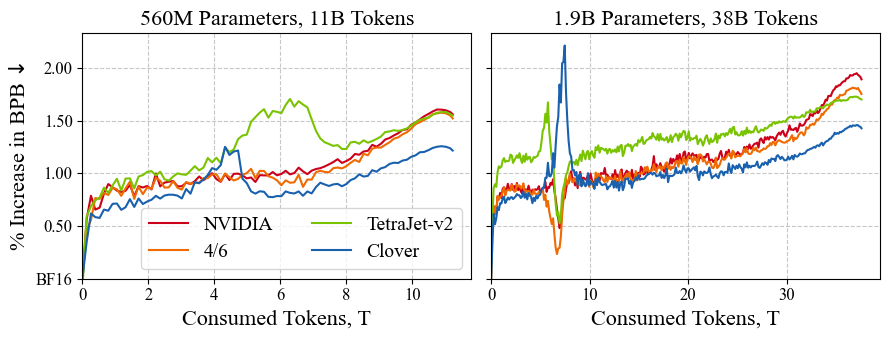

In [15]:
# 4. Plotting
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)

method_label_color = {
    "nvidia-python16x16": ("NVIDIA", red),
    "46": ("4/6", orange),
    "tetrajetv2": ("TetraJet-v2", green),
    "quartet2": ("Clover", blue),
    
    "1000-nvidia": ("NVIDIA", red),
    "1000-46": ("4/6", orange),
    "1000-tetrajetv2": ("TetraJet-v2", green),
    "1000-quartet_v2": ("Clover", blue),
}

for method_name, method_vals in processed_methods.items():
    if method_name.startswith("1000-"):
        group_key = "1000-"
        base_name = BASELINE_MAP["1000-"]
        ax=ax1
    else:
        group_key = "default"
        base_name = BASELINE_MAP["default"]
        ax=ax0
    
    if method_name in BASELINE_MAP.values():
        continue 

    # Re-verify alignment just in case baseline was processed after this method
    base_vals = processed_methods[base_name]
    ref_steps = references[base_name]

    # Calculate % Increase
    pct_increase = ((method_vals - base_vals) / base_vals) * 100
    consumed_tokens = [step * 524288 * 1e-9 for step in ref_steps]
    
    label, color = method_label_color[method_name]
    
    
    ax.plot(consumed_tokens, pct_increase, label=label, linewidth=1.5, color=color)

for ax in [ax0, ax1]:
    ax.set_xlabel("Consumed Tokens, T")
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.grid(True, linestyle='--', alpha=0.7)

ax0.set_title("560M Parameters, 11B Tokens", fontsize=16)
ax1.set_title("1.9B Parameters, 38B Tokens", fontsize=16)

ax0.legend(fontsize=14, loc="lower right", ncols=2)
ax0.set_ylabel(r"% Increase in BPB$\downarrow$")

y_ticks = ax0.get_yticks()
y_ticklabels = [f"{y:.2f}" if abs(y) > 1e-8 else "BF16" for y in y_ticks]
ax0.set_yticklabels(y_ticklabels)

fig.tight_layout()

fig.savefig("../figures/nanochat_curves.pdf", transparent=True, bbox_inches="tight")

plt.show()

# Speedups

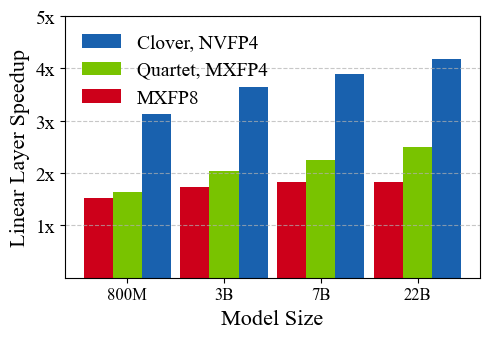

In [16]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_model_logs(log_text):
    results = {}
    current_size = None
    
    # Pattern to match the model size (e.g., 100M, 7B)
    size_pattern = re.compile(r'^(\d+[M|B]):')
    
    # Pattern to match the percentage lines: 
    # Group 1: type (nvfp4/mxfp4), Group 2: forward %, Group 3: forward+backward %
    percent_pattern = re.compile(r'^\s+(nvfp4|mxfp4|mxfp8):\s+([\d\.]+)%\s+forward,\s+([\d\.]+)%\s+forward\+backward')

    for line in log_text.strip().split('\n'):
        # Check if line is a new model size header
        size_match = size_pattern.match(line)
        if size_match:
            current_size = size_match.group(1)
            results[current_size] = {}
            continue
            
        # Check if line contains the percentage data
        percent_match = percent_pattern.match(line)
        if percent_match and current_size:
            label = percent_match.group(1)   # 'nvfp4' or 'mxfp4'
            fwd_pct = float(percent_match.group(2))
            fwd_bwd_pct = float(percent_match.group(3))
            
            # Store as a tuple of floats
            results[current_size][label] = (fwd_pct, fwd_bwd_pct)
            
    return results

# Example Usage:
log_data = """800M:
        nvfp4:   1.80 ms forward,   7.71 ms forward+backward
        mxfp4:   1.77 ms forward,  14.65 ms forward+backward
        mxfp8:   3.06 ms forward,  15.73 ms forward+backward
        nvfp4: 415.33%   forward, 312.26%   forward+backward
        mxfp4: 422.50%   forward, 164.32%   forward+backward
        mxfp8: 244.68%   forward, 153.06%   forward+backward
3B:
        nvfp4:   3.54 ms forward,  14.01 ms forward+backward
        mxfp4:   3.51 ms forward,  25.07 ms forward+backward
        mxfp8:   6.54 ms forward,  29.26 ms forward+backward
        nvfp4: 465.06%   forward, 364.01%   forward+backward
        mxfp4: 469.60%   forward, 203.35%   forward+backward
        mxfp8: 251.92%   forward, 174.23%   forward+backward
7B:
        nvfp4:   5.94 ms forward,  22.66 ms forward+backward
        mxfp4:   5.97 ms forward,  39.21 ms forward+backward
        mxfp8:  11.51 ms forward,  48.12 ms forward+backward
        nvfp4: 475.30%   forward, 389.31%   forward+backward
        mxfp4: 473.45%   forward, 224.99%   forward+backward
        mxfp8: 245.35%   forward, 183.35%   forward+backward
22B:
        nvfp4:  12.78 ms forward,  46.22 ms forward+backward
        mxfp4:  12.91 ms forward,  77.62 ms forward+backward
        mxfp8:  28.67 ms forward, 106.22 ms forward+backward
        nvfp4: 488.65%   forward, 418.50%   forward+backward
        mxfp4: 483.79%   forward, 249.22%   forward+backward
        mxfp8: 217.78%   forward, 182.12%   forward+backward"""
parsed_data = parse_model_logs(log_data)

# Maintain model size categorical as original strings (in the order appearing in the log)
sizes_in_order = []
nvfp4_speedups = []
mxfp4_speedups = []
mxfp8_speedups = []
for line in log_data.strip().split('\n'):
    match = re.match(r'^(\d+[M|B]):', line)
    if match:
        sz = match.group(1)
        if sz in parsed_data and 'nvfp4' in parsed_data[sz] and 'mxfp4' in parsed_data[sz]:
            sizes_in_order.append(sz)
            nvfp4_speedups.append(parsed_data[sz]['nvfp4'][1])
            mxfp4_speedups.append(parsed_data[sz]['mxfp4'][1])
            mxfp8_speedups.append(parsed_data[sz]['mxfp8'][1])

x = np.arange(len(sizes_in_order))
width = 0.30

fig, ax = plt.subplots(figsize=(5,3.5))

bar1 = ax.bar(x + width, nvfp4_speedups, width, label="Clover, NVFP4", color=blue)
bar2 = ax.bar(x, mxfp4_speedups, width, label="Quartet, MXFP4", color=green)
bar3 = ax.bar(x - width, mxfp8_speedups, width, label="MXFP8", color=red)

ax.set_ylabel("Linear Layer Speedup")
ax.set_xlabel("Model Size")
ax.set_xticks(x)
ax.set_xticklabels(sizes_in_order)

ax.set_yticks([100, 200, 300, 400, 500])
ax.set_yticklabels(["1x", "2x", "3x", "4x", "5x"], fontsize=14)

ax.legend(fontsize=14, loc="upper left", ncols=1, frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# # Annotate bar tops with values
# for rects in [bar1, bar2, bar3]:
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.0f}%',
#                     xy=(rect.get_x() + rect.get_width()/2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=9)

ax.set_ylim(0, 500)

fig.tight_layout()

fig.savefig("../figures/linear_speedup.pdf", transparent=True, bbox_inches="tight")

plt.show()

# Concentraiton

In [17]:
import json

concentrations = {}

with open("../data/nvidia_concentration.json", "r") as f:
    concentrations["nvidia"] = json.load(f)
    
with open("../data/46_concentration.json", "r") as f:
    concentrations["46"] = json.load(f)
    
with open("../data/tetrajetv2_concentration.json", "r") as f:
    concentrations["tetrajetv2"] = json.load(f)
    
with open("../data/quartetII_concentration.json", "r") as f:
    concentrations["quartet2"] = json.load(f)

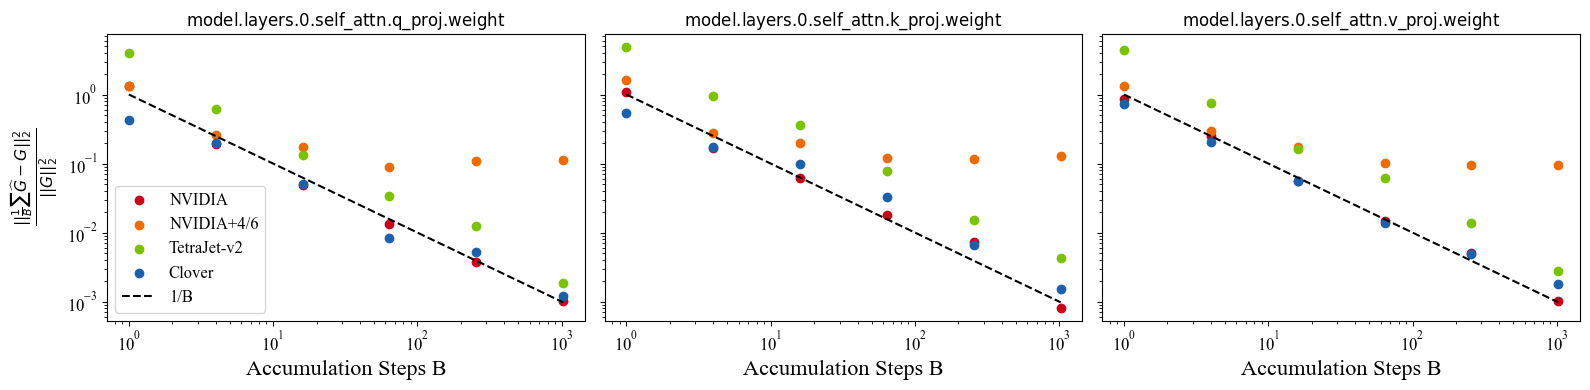

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

method_label_color = {
    "nvidia": ("NVIDIA", red),
    "46": ("NVIDIA+4/6", orange),
    "tetrajetv2": ("TetraJet-v2", green),
    "quartet2": ("Clover", blue),
}

key_marker = {
    "model.layers.0.self_attn.q_proj.weight": "o",
    "model.layers.0.self_attn.k_proj.weight": "o",
    "model.layers.0.self_attn.v_proj.weight": "o",
}

for ax, (key, marker) in zip(axs, key_marker.items()):
    for method, (label, color) in method_label_color.items():
        data = concentrations[method][key]
        data = {int(k): float(v) for k, v in data.items()}
        
        ax.scatter(data.keys(), data.values(), label=label, color=color, marker=marker)

    x = np.logspace(0, 5, num=50, base=4)
    y = 1 / x

    ax.plot(x, y, color="black", linestyle="--", label="1/B")

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel("Accumulation Steps B")
    
    ax.set_title(r"$\text{"+key+r"}$")

axs[0].legend(loc="lower left", fontsize=12)
axs[0].set_ylabel(r"$\frac{||\frac{1}{B}\sum\widehat{G} - G||_2^2}{||G||_2^2}$")

fig.tight_layout()

fig.savefig("../figures/concentration.pdf", transparent=True, bbox_inches="tight")

plt.show()